# catboost 를 이용한 자전거 수요예측 정리

### 라이브러리를 불러오자

In [74]:

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import sqrt
import os
import missingno as msno
import calendar
import datetime
from math import sqrt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

#models
# import lightgbm as lgbm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

#최적화
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

#Xai
from functools import partial 
import shap

### 데이터 준비

In [2]:
def make_di(data):
    data['di'] = 1.8*data['temp']-0.55*(1-(data['humidity']/100))*(1.8*data['temp']-26)
    return data

In [20]:
# test_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/test_eda.csv"
# train_path = "/content/drive/MyDrive/함께하조/기계학습과 딥러닝/data/kaggle_data/train_eda.csv"

## 주피터용
test_path = "test_eda.csv"
train_path = "train_eda.csv"
train_og = pd.read_csv('train.csv')
test_og = pd.read_csv('test.csv')

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

test.drop("Unnamed: 0", axis=1, inplace=True)
train.drop("Unnamed: 0", axis=1, inplace=True)

#cat features
cat_col = ["season", "Year","weather", "Day of week","Month", "Hour","Day_info"]
for col in cat_col:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

#train, valid split
days = list(range(1, 15))
train_d = train.loc[train['Day'].isin(days)]
test_d = train.loc[~(train['Day'].isin(days))]

#target, drop, y
target_col = "count"
drop_cols = ["datetime", "workingday", "holiday", "Day", "Year","sin_hour", "cos_hour", target_col]

####
# train = make_di(train)
# last_target = train['count']
# train_d = make_di(train_d)
# test_d = make_di(test_d)
# test = make_di(test)

# train_d.drop(columns = 'temp',inplace = True)
# test_d.drop(columns = 'temp',inplace = True)
# test.drop(columns = 'temp',inplace = True)
# train.drop(columns = 'temp',inplace = True)

cat_col = ["season", "weather", "Day of week", "Month", "Hour", "Day_info"]

## category 지원 안되는 전용
# train = pd.get_dummies(train, columns=cat_col,drop_first = True)
# test = pd.get_dummies(test, columns=cat_col,drop_first = True)
# test_d = pd.get_dummies(test_d, columns=cat_col,drop_first = True)
# train_d = pd.get_dummies(train_d, columns=cat_col,drop_first = True)

## catboost 전용
train_d[cat_col] = train_d[cat_col].astype("category")
test_d[cat_col] = test_d[cat_col].astype("category")
train[cat_col] = train[cat_col].astype("category")
test[cat_col] = test[cat_col].astype("category")


####
test = test.drop(columns = ["datetime", "workingday", "holiday", "Day", "Year","sin_hour", "cos_hour"],axis = 1)
train.drop(drop_cols,axis=1,inplace = True)
x_train, y_train = train_d.drop(drop_cols, axis=1), train_d[target_col]
x_test, y_test = test_d.drop(drop_cols, axis=1), test_d[target_col]

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_train.head()

season weather  temp  humidity  windspeed Day of week Month Hour Day_info
0      1    Good  9.84        81        0.0    Saturday     1    0  Weekend
1      1    Good  9.02        80        0.0    Saturday     1    1  Weekend
2      1    Good  9.02        80        0.0    Saturday     1    2  Weekend
3      1    Good  9.84        75        0.0    Saturday     1    3  Weekend
4      1    Good  9.84        75        0.0    Saturday     1    4  Weekend

### 데이터 소개

In [21]:
print(f'x_train.shape -> {x_train.shape}, y_train.shape -> {y_train.shape}')
print(f'x_test.shape -> {x_test.shape},y_test.shape -> {y_test.shape }')
print(f'train.shape -> {train.shape}, last_target.shape -> {last_target.shape }')

x_train.shape -> (8026, 9), y_train.shape -> (8026,)
x_test.shape -> (2860, 9),y_test.shape -> (2860,)
train.shape -> (10886, 9), last_target.shape -> (10886,)


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   season       10886 non-null  category
 1   weather      10886 non-null  category
 2   temp         10886 non-null  float64 
 3   humidity     10886 non-null  int64   
 4   windspeed    10886 non-null  float64 
 5   Day of week  10886 non-null  category
 6   Month        10886 non-null  category
 7   Hour         10886 non-null  category
 8   Day_info     10886 non-null  category
dtypes: category(6), float64(2), int64(1)
memory usage: 321.0 KB


### optuna and rmsle

In [26]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [ ]:
    cat_param = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "8gb",
        'cat_features': cat_col,
    }

In [31]:
def objective(trial):
    cat_param = {
        'iterations':trial.suggest_int("iterations", 500, 2000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_float('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_float('reg_lambda',1e-2,100),
        'subsample': trial.suggest_float('subsample',0,1),
        'random_strength': trial.suggest_float('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "8gb",
        'cat_features': cat_col,
    }
    
    n_splits=5
    random_state=42
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_index, valid_index in kf.split(X=x_train, y=y_train):
        X_train, Y_train = x_train.iloc[train_index], y_train[train_index]
        X_valid, Y_valid = x_train.iloc[valid_index], y_train[valid_index]

        model = CatBoostRegressor(**cat_param)
        model.fit(X_train, np.log1p(Y_train),verbose=0)

        xg_pred = model.predict(X_valid)
        scores.append(rmsle(np.log1p(Y_valid), xg_pred))
    
    return np.mean(scores)

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="catboost_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [32]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="catboost_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-23 09:38:33,659] A new study created in memory with name: catboost_parameter_opt
[I 2023-03-23 09:38:47,636] Trial 0 finished with value: 0.6821378002525685 and parameters: {'iterations': 1062, 'od_wait': 2212, 'learning_rate': 0.7322619478695936, 'reg_lambda': 59.86986183486169, 'subsample': 0.15601864044243652, 'random_strength': 16.239780813448107, 'depth': 1, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 10, 'bagging_temperature': 70.81017705382659, 'colsample_bylevel': 0.41235069657748147, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.6821378002525685.
[I 2023-03-23 09:38:57,354] Trial 1 finished with value: 0.3648753419426497 and parameters: {'iterations': 818, 'od_wait': 827, 'learning_rate': 0.18422110534358038, 'reg_lambda': 30.431181873524178, 'subsample': 0.5247564316322378, 'random_strength': 27.27780074568463, 'depth': 5, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 3, 'bagging_temperature': 29.221543407036464, 'colsample_bylevel': 

Best Score: 0.35492766212072646
Best trial: {'iterations': 1674, 'od_wait': 1265, 'learning_rate': 0.03580043225079321, 'reg_lambda': 72.22889661832619, 'subsample': 0.3249903742096951, 'random_strength': 12.316890375887539, 'depth': 8, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 14, 'bagging_temperature': 49.47062545156002, 'colsample_bylevel': 0.9081028436856866, 'boosting_type': 'Plain'}


### 점수를 뽑아내보자

In [75]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 0.35492766212072646
Best trial: {'iterations': 1674, 'od_wait': 1265, 'learning_rate': 0.03580043225079321, 'reg_lambda': 72.22889661832619, 'subsample': 0.3249903742096951, 'random_strength': 12.316890375887539, 'depth': 8, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 14, 'bagging_temperature': 49.47062545156002, 'colsample_bylevel': 0.9081028436856866, 'boosting_type': 'Plain'}


In [76]:
last_x,eval_x,last_y,eval_y = train_test_split(train,last_target,random_state = 42)

In [77]:
## 최종 모델 학습
op_tuned = CatBoostRegressor(**study.best_trial.params,random_state=42,cat_features = cat_col,
                            use_best_model = True,
                            eval_metric = 'RMSE')

op_tuned.fit(last_x,np.log(last_y),verbose = 0,eval_set = [(eval_x,np.log1p(eval_y))])


### sub mission 제출

In [43]:
# i=2
i=4
pred = op_tuned.predict(test)
# sub = pd.read_csv('sampleSubmission.csv')
# sub['count'] = np.exp(pred)
# sub.to_csv(f'cat_boost_final{i}.csv',index=False)

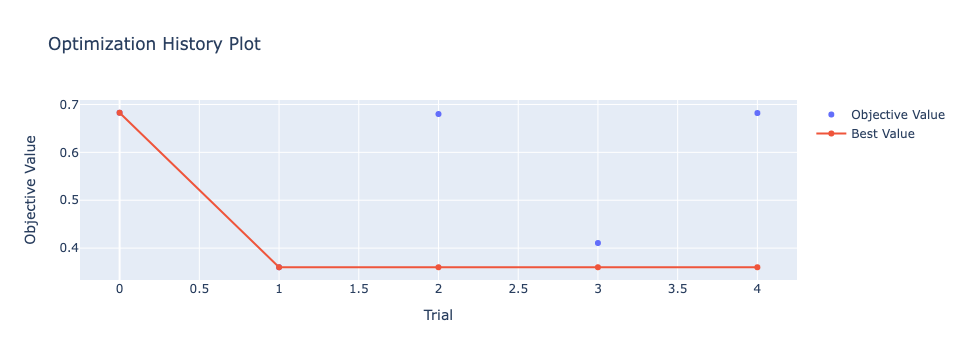

In [29]:
### 나머지 시각화
# 시각화
optuna.visualization.plot_optimization_history(study)

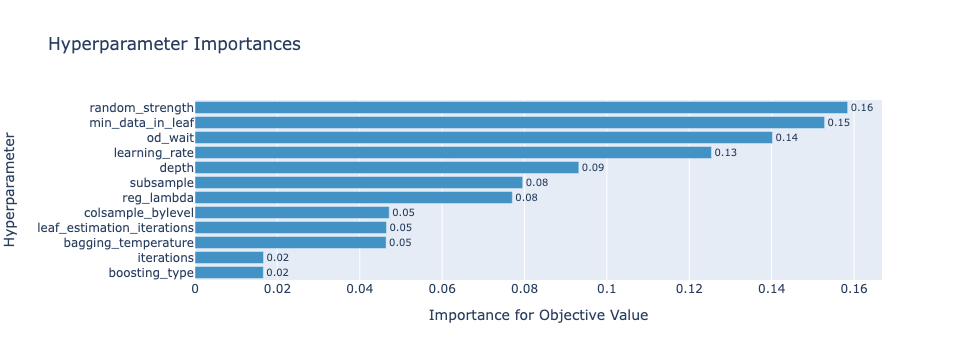

In [30]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

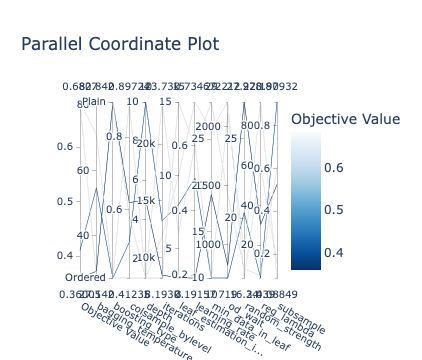

In [31]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

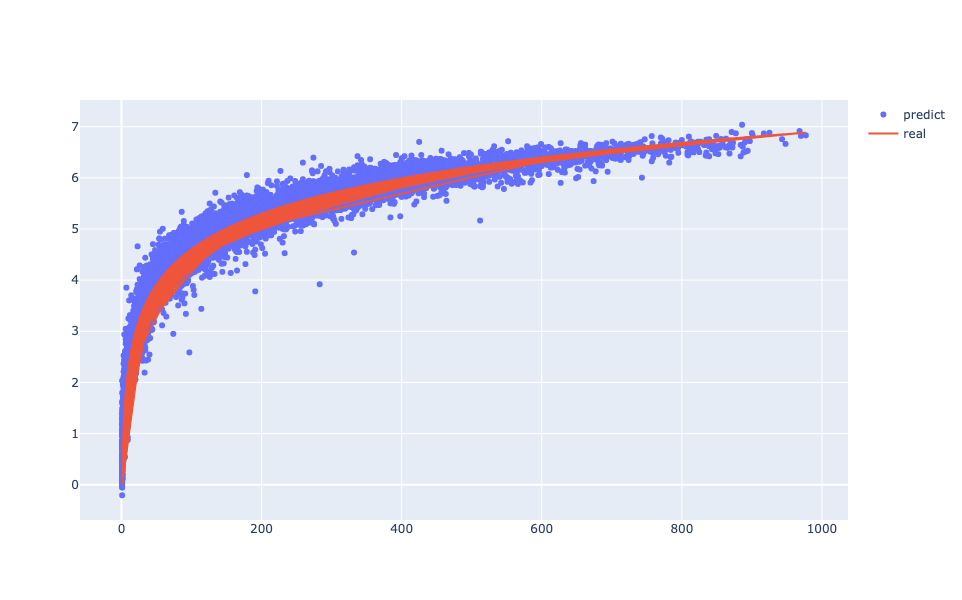

In [33]:
pre = op_tuned.predict(train)
fig = go.Figure()
fig.add_trace(go.Scatter(x=last_target, y=pre, mode="markers", name="predict"))
fig.add_trace(go.Scatter(x=last_target, y=np.log(last_target), mode="lines", name="real"))
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.show()

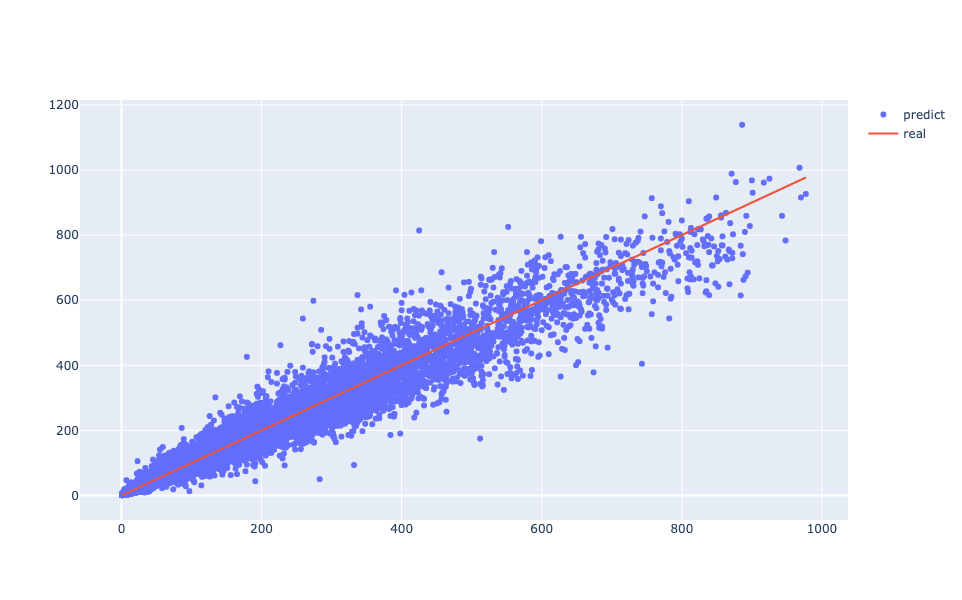

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=last_target, y=np.exp(pre), mode="markers", name="predict"))
fig.add_trace(go.Scatter(x=last_target, y=last_target, mode="lines", name="real"))
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.show()

In [44]:
## 짬짬한 eda

In [50]:
train_eda = pd.read_csv('train_eda.csv',index_col=0)

In [51]:
train_eda.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'count', 'Day of week', 'Year', 'Month', 'Day',
       'Hour', 'Day_info', 'sin_hour', 'cos_hour'],
      dtype='object')

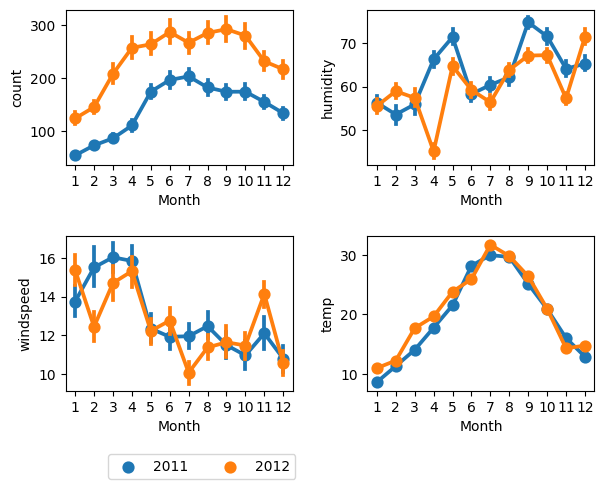

In [73]:
fig, ax = plt.subplots(ncols=2,nrows=2)

sns.pointplot(x = 'Month',y = 'count',hue='Year',data=train_eda, ax = ax[0][0])
sns.pointplot(x = 'Month',y = 'humidity',hue='Year',data=train_eda,ax = ax[0][1])
sns.pointplot(x = 'Month',y = 'windspeed',hue='Year',data=train_eda,ax = ax[1][0])
sns.pointplot(x = 'Month',y = 'temp',hue='Year',data=train_eda,ax = ax[1][1])

# handles, labels = ax[0][0].get_legend_handles_labels() 
fig.legend(handles, labels, loc='lower right', ncol=2, bbox_to_anchor=[0.5,-0.05])
ax[1][0].get_legend().set_visible(False)
ax[0][1].get_legend().set_visible(False)
ax[1][1].get_legend().set_visible(False)
ax[0][0].get_legend().set_visible(False)
plt.tight_layout(pad=2) # 간격 조정
plt.show()

## Shap 시각화

In [116]:
# ['season', 'weather', 'Day of week', 'Month', 'Hour', 'Day_info'] 
# 이곳에서 정수형으로 변환 불가능한 열에 대해서만 진행해준다.
# 아니다 샤프에서도 지정해줄수있나보다.

In [120]:
# real_cat = ['weather','Day of week','Day_info']
# num = ['Month','Hour','season']

In [ ]:
# def convert_cat(x_test,real_cat,num):
#     x_cat_test = pd.get_dummies(x_test,columns = real_cat,drop_first = True)
#     x_cat_test[num] = x_cat_test[num].astype('float')
#     return x_cat_test

In [166]:
# x_cat_train = convert_cat(x_train,real_cat,num)
# x_cat_train.head(2);

In [167]:
# x_cat_test;

In [170]:
cat_model = CatBoostRegressor(**study.best_trial.params,eval_metric = 'RMSE'
                              ,use_best_model = True
                             ,cat_features = cat_col)

In [171]:
cat_model.fit(x_train,np.log(y_train),eval_set = (x_test,np.log(y_test)))

0:	learn: 1.4687683	test: 1.4262892	best: 1.4262892 (0)	total: 22.7ms	remaining: 38s
1:	learn: 1.4367707	test: 1.3933209	best: 1.3933209 (1)	total: 38.8ms	remaining: 32.4s
2:	learn: 1.4028422	test: 1.3577512	best: 1.3577512 (2)	total: 54.6ms	remaining: 30.4s
3:	learn: 1.3727530	test: 1.3270439	best: 1.3270439 (3)	total: 67.2ms	remaining: 28.1s
4:	learn: 1.3417712	test: 1.2952114	best: 1.2952114 (4)	total: 76ms	remaining: 25.4s
5:	learn: 1.3136797	test: 1.2650024	best: 1.2650024 (5)	total: 82.2ms	remaining: 22.8s
6:	learn: 1.2993916	test: 1.2504003	best: 1.2504003 (6)	total: 84.8ms	remaining: 20.2s
7:	learn: 1.2750290	test: 1.2254391	best: 1.2254391 (7)	total: 89.4ms	remaining: 18.6s
8:	learn: 1.2509857	test: 1.2000450	best: 1.2000450 (8)	total: 94.4ms	remaining: 17.5s
9:	learn: 1.2284068	test: 1.1745515	best: 1.1745515 (9)	total: 98ms	remaining: 16.3s
10:	learn: 1.2094245	test: 1.1548569	best: 1.1548569 (10)	total: 102ms	remaining: 15.5s
11:	learn: 1.1877766	test: 1.1333079	best: 1.133

In [172]:
import shap
from multiprocessing import Pool
# Fits the explainer
explainer = shap.TreeExplainer(cat_model)
# , x_test, cat_features = cat_col
# Calculates the SHAP values - It takes some time
# shap_values = explainer(x_test)
#, cat_features=cat_col
shap_values = explainer.shap_values(x_test)

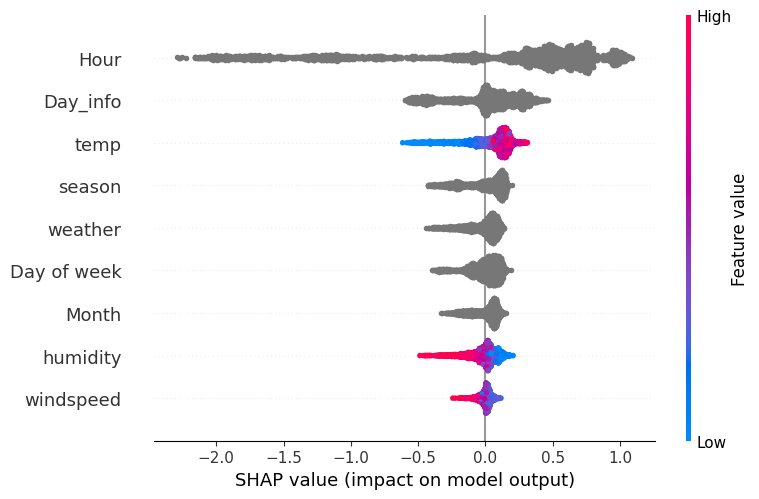

In [174]:
shap.summary_plot(shap_values,x_test)
## 역시 카테고리형 변수에 대해서 처리를 잘못해주는 느낌이다.

In [175]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])


In [176]:
print('예측한 3.39 의 np.exp 지수값 e^3.39 ->',np.exp(3.39),'\n 실제 y_test의 1번째 값 ->',y_test.iloc[0,])

예측한 3.39 의 np.exp 지수값 e^3.39 -> 29.665952270368855 
 실제 y_test의 1번째 값 -> 28


### waterfall graph

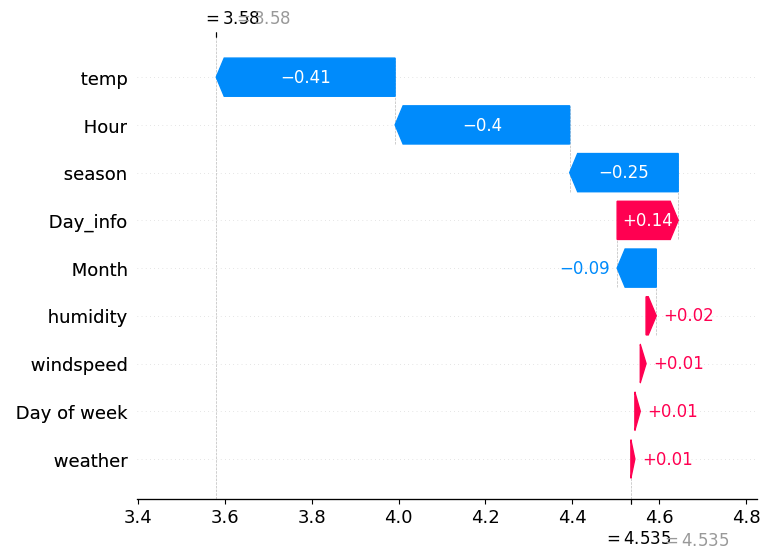

In [177]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                       shap_values[0,:],
                                    features = x_test.iloc[0,:])